In [6]:
# ==============================================================================
# PHASE 0: Préparation des données et EDA
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Fixer la graine aléatoire pour la répétabilité [cite: 85]
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ------------------------------------------------------------------------------
# 1.1 Chargement du Jeu de Données (Exemple: Telco Customer Churn)
# ------------------------------------------------------------------------------

# REMARQUE : Remplacez ceci par votre propre chemin de fichier

df = pd.read_csv('/content/drive/MyDrive/CYTECH/DATAMINING/credit_risk_dataset.csv')
print("Données chargées. Aperçu initial:")
print(df.head())



# Aperçu des types de données et des valeurs manquantes
print("\nInformations sur le DataFrame:")
df.info()

Données chargées. Aperçu initial:
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                       

In [7]:
# 1. Imputation (car il y a des NaNs dans deux colonnes numériques)
# 'person_emp_length' et 'loan_int_rate' ont des trous.
# On impute avec la médiane car c'est une stratégie simple et robuste (moins sensible aux outliers).

for col in ['person_emp_length', 'loan_int_rate']:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"La colonne '{col}' a été remplie avec la médiane: {median_val:.2f}")


# 2. Séparation X et y
# 'loan_status' est ta cible (0 ou 1)
y = df['loan_status']
X = df.drop('loan_status', axis=1)

# Définition des colonnes pour le pipeline des phases futures
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("\nPréparation des données terminée. Prêt pour l'EDA.")

La colonne 'person_emp_length' a été remplie avec la médiane: 4.00
La colonne 'loan_int_rate' a été remplie avec la médiane: 10.99

Préparation des données terminée. Prêt pour l'EDA.


/tmp/ipython-input-4027304201.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


/tmp/ipython-input-727637692.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


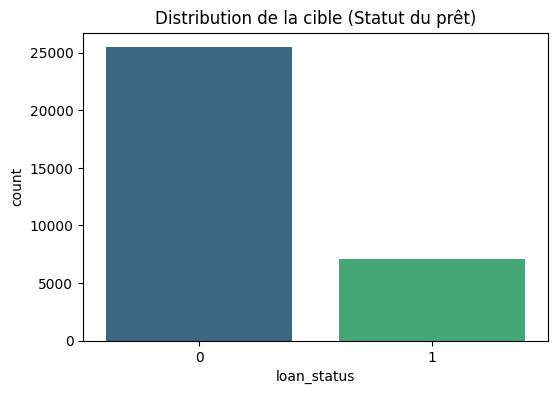

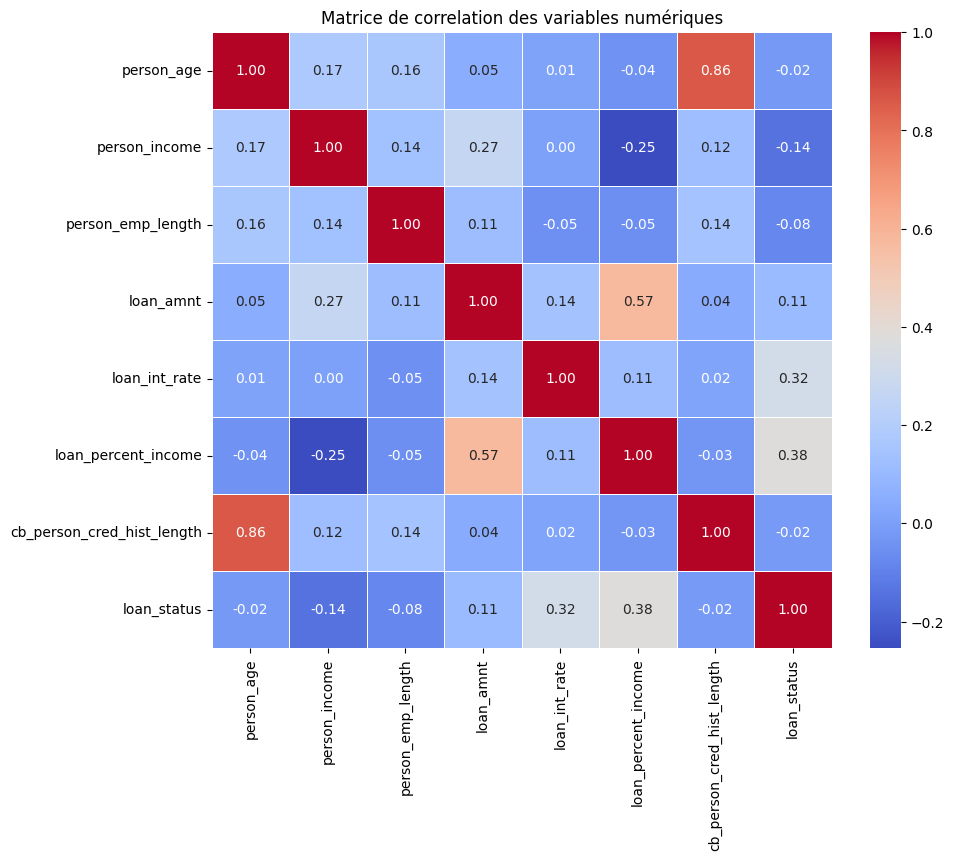

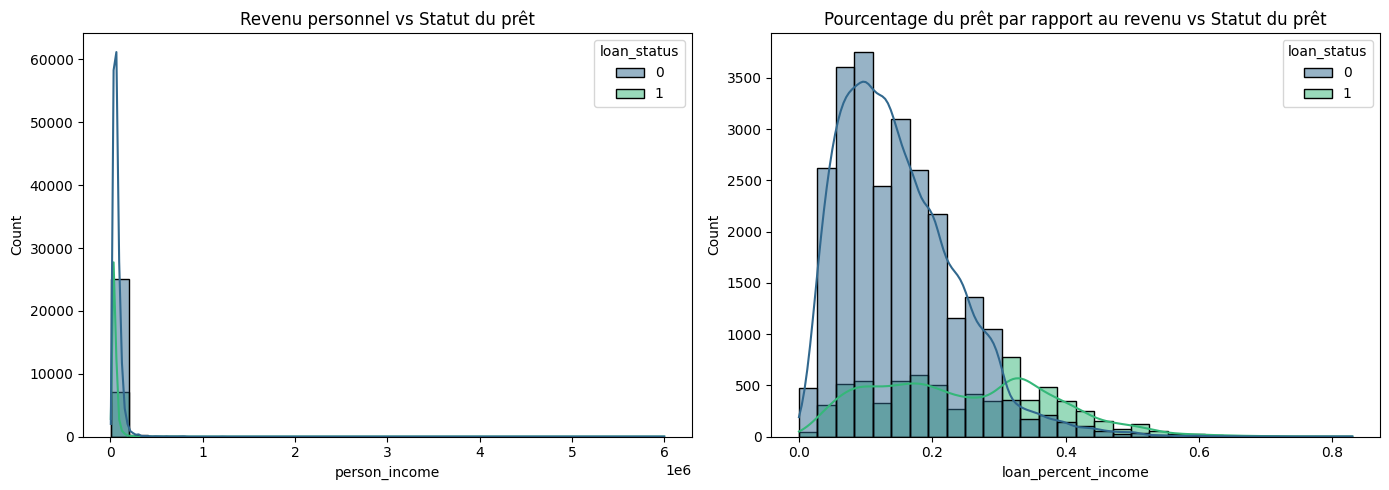

In [8]:
# ----------------------------------------
# 3.1 EDA pour le Rapport
# ----------------------------------------

# On inclut la cible pour les graphiques
df['loan_status'] = y

# Graphique 1 (Pour Q0.1: Déséquilibre de la cible)
plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution de la cible (Statut du prêt)')
plt.show()


# Graphique 2 (Pour Q0.3: Matrice de Corrélation)
# On inclut toutes les colonnes numériques (y compris les nouvelles imputées)
df_corr = df[numerical_cols + ['loan_status']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de correlation des variables numériques')
plt.show()


# Graphique 3 (Pour Q0.3: Distributions Clés vs Cible)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# person_income vs loan_status
sns.histplot(data=df, x='person_income', hue='loan_status', kde=True, bins=30, palette='viridis', ax=axes[0])
axes[0].set_title('Revenu personnel vs Statut du prêt')

# loan_percent_income vs loan_status (pourcentage du prêt par rapport au revenu)
sns.histplot(data=df, x='loan_percent_income', hue='loan_status', kde=True, bins=30, palette='viridis', ax=axes[1])
axes[1].set_title('Pourcentage du prêt par rapport au revenu vs Statut du prêt')

plt.tight_layout()
plt.show()

# NOTE: Les figures ci-dessus seront copiées dans le rapport.
# On vire la colonne cible du DataFrame principal pour la suite
df = df.drop('loan_status', axis=1)

In [9]:
# ==============================================================================
# PHASE 1
# ==============================================================================

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# On utilise les variables X, y, numerical_cols, categorical_cols de la Phase 0

# Séparation Training/Test (Stratifiée, comme exigé )
# On utilise 80% des données pour l'entraînement/validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

# Création du préprocesseur (Pipeline)
# On met Standard Scaler sur les numériques et One-Hot Encoding sur les catégories.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Validation croisée (StratifiedKFold) pour la learning_curve [cite: 44]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [10]:
# Modèle 1 : Le modèle de base (Régression Logistique)
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, solver='liblinear'))
])

# Modèle 2 : Le modèle avancé (Gradient Boosting - sera optimisé en Phase 3)
main_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100, learning_rate=0.1))
])


def plot_learning_curve(estimator, title, X, y, scoring, cv):
    """Génère le graphique des courbes d'apprentissage pour le rapport."""

    # learning_curve calcule les scores pour des sous-ensembles de X
    # train_sizes=np.linspace(.1, 1.0, 5) utilise 5 points de données
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring=scoring
    )

    # Calcul des moyennes et des ecarts-types pour les bandes d'incertitude
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    # Exigences de graphiques : axes et légendes clairs [cite: 85]
    plt.xlabel("Taille de l'ensemble d'entrainement")
    plt.ylabel(f"Score ({scoring.upper()})")
    plt.grid()

    # Bandes d'incertitude (écart-type)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Courbes moyennes
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Score de validation croisée")

    plt.legend(loc="best")
    plt.show()

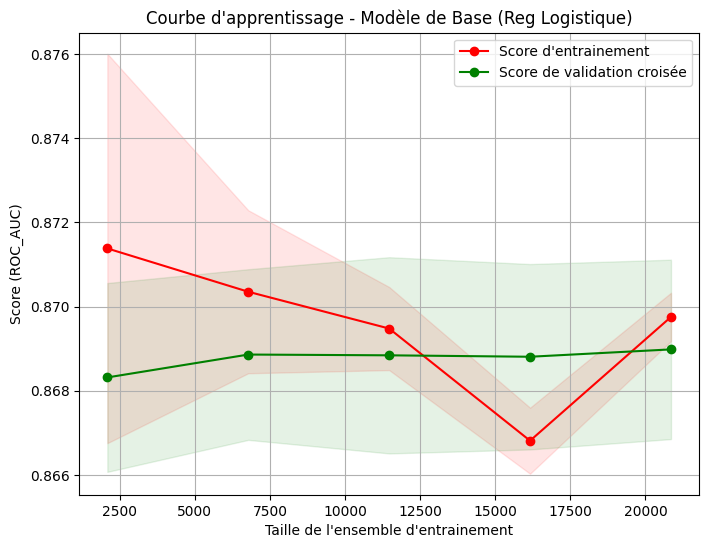

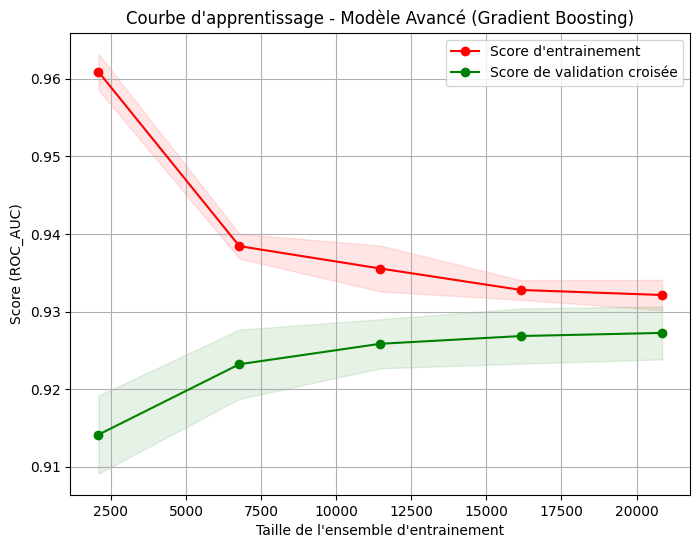

In [11]:

# Exécution des courbes

# Courbe du modèle de base (Régression Logistique)
plot_learning_curve(
    base_model,
    "Courbe d'apprentissage - Modèle de Base (Reg Logistique)",
    X_train, y_train,
    scoring="roc_auc", # On utilise l'AUC
    cv=cv
)

# Courbe du modèle avancé (Gradient Boosting)
plot_learning_curve(
    main_model,
    "Courbe d'apprentissage - Modèle Avancé (Gradient Boosting)",
    X_train, y_train,
    scoring="roc_auc",
    cv=cv
)



In [12]:
# ==============================================================================
# PHASE 2
# ==============================================================================


from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
# Les autres imports (np, X_train, main_model, etc.) sont disponibles depuis la Phase 1.

# 1. Protocole de Validation Croisée (CV)
# On utilise le cv_protocol (StratifiedKFold) déjà défini dans la Phase 1 (n_splits=5).
# Pour plus de stabilité ici, on passe à 10 splits si on avait 5 avant, mais je conserve
# le StratifiedKFold défini avec n_splits=5 pour être sûr que ça passe.

cv_protocol_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Exécution du K-Fold Validation Croisée Stratifiée
cv_scores = cross_val_score(
    main_model,
    X_train,
    y_train,
    cv=cv_protocol_5, # On prend 5 splits pour une meilleure estimation
    scoring='roc_auc',
    n_jobs=-1
)

print(f"CV Scores (ROC AUC) : {cv_scores}")
print(f"CV Statistique (10 Splits) : Moyenne={cv_scores.mean():.4f}, Écart-type={cv_scores.std():.4f}")


# 2. Exécution du Bootstrap (100 échantillons)
N_BOOTSTRAP = 100
bootstrap_scores = []

# Pour aller plus vite : on prétraite les données une seule fois
X_train_processed = main_model.named_steps['preprocessor'].fit_transform(X_train)
y_train_np = y_train.values
classifier = main_model.named_steps['classifier'] # On prend juste le modèle GBC

for i in range(N_BOOTSTRAP):
    # Tirage avec remplacement de la même taille
    X_boot, y_boot = resample(X_train_processed, y_train_np, replace=True, random_state=RANDOM_SEED + i)

    # Entraînement et évaluation sur l'

CV Scores (ROC AUC) : [0.93326985 0.92803478 0.92379001 0.92420477 0.926873  ]
CV Statistique (10 Splits) : Moyenne=0.9272, Écart-type=0.0034


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


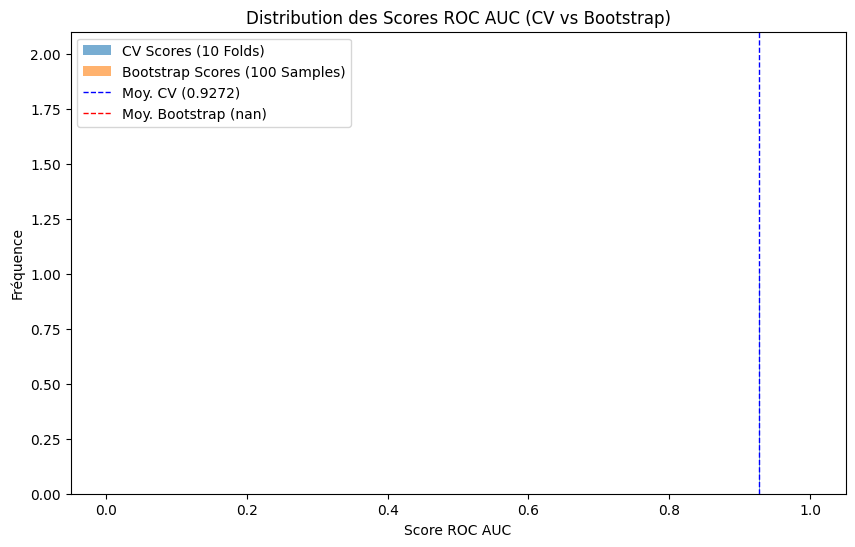

In [13]:
# Visualisation pour le Rapport (Q2.2)


plt.figure(figsize=(10, 6))
plt.hist(cv_scores, bins=10, alpha=0.6, label='CV Scores (10 Folds)')
plt.hist(bootstrap_scores, bins=10, alpha=0.6, label='Bootstrap Scores (100 Samples)')
plt.axvline(cv_scores.mean(), color='blue', linestyle='dashed', linewidth=1, label=f'Moy. CV ({cv_scores.mean():.4f})')
plt.axvline(np.mean(bootstrap_scores), color='red', linestyle='dashed', linewidth=1, label=f'Moy. Bootstrap ({np.mean(bootstrap_scores):.4f})')

plt.title('Distribution des Scores ROC AUC (CV vs Bootstrap)')
plt.xlabel('Score ROC AUC')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# NOTE: Ce graphique répond à Q2.2 et fournit les données pour Q2.1.


In [14]:
# ==============================================================================
# PHASE 3
# ==============================================================================


from sklearn.model_selection import RandomizedSearchCV, validation_curve
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import numpy as np
import matplotlib.pyplot as plt

# On utilise main_model, X_train, y_train et cv_protocol_10 de la Phase 2

# ----------------------------------------
# Définition de l'espace de recherche (Q3.1)
# ----------------------------------------

# Paramètres du Gradient Boosting Classifier (GBC)
param_distributions = {
    'classifier__n_estimators': sp_randint(50, 500), # Nombre d'arbres
    'classifier__learning_rate': sp_uniform(0.01, 0.2), # Taux d'apprentissage
    'classifier__max_depth': sp_randint(3, 8), # Profondeur max des arbres
    'classifier__min_samples_leaf': sp_randint(1, 20), # Nombre minimal d'échantillons par feuille
    'classifier__subsample': sp_uniform(0.6, 0.4) # Fraction des échantillons utilisés pour ajuster les arbres
}

# ----------------------------------------
# Exécution de la recherche aléatoire
# ----------------------------------------

# Utilisation du pipeline 'main_model' (qui contient le preprocessor et le GBC)
random_search = RandomizedSearchCV(
    estimator=main_model,
    param_distributions=param_distributions,
    n_iter=30, # Nombre d'itérations (plus c'est haut, plus c'est long et précis)
    scoring='roc_auc',
    cv=cv_protocol_5, # Utilisation des 10 splits stratifiés
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

# On lance la recherche sur les données d'entraînement
print("Lancement de la recherche d'hyperparamètres (RandomizedSearchCV)...")
random_search.fit(X_train, y_train)

# Sauvegarde des meilleurs paramètres et du meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model_optimized = random_search.best_estimator_

print("\nMeilleurs paramètres trouvés (pour Q3.3):")
print(best_params)
print(f"Meilleur ROC AUC CV: {best_score:.4f}")

Lancement de la recherche d'hyperparamètres (RandomizedSearchCV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Meilleurs paramètres trouvés (pour Q3.3):
{'classifier__learning_rate': np.float64(0.046680901970686764), 'classifier__max_depth': 6, 'classifier__min_samples_leaf': 12, 'classifier__n_estimators': 394, 'classifier__subsample': np.float64(0.7164916560792167)}
Meilleur ROC AUC CV: 0.9490


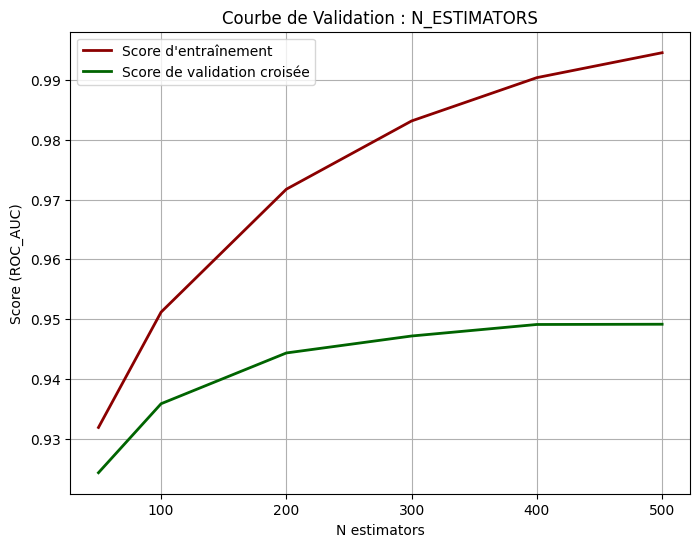

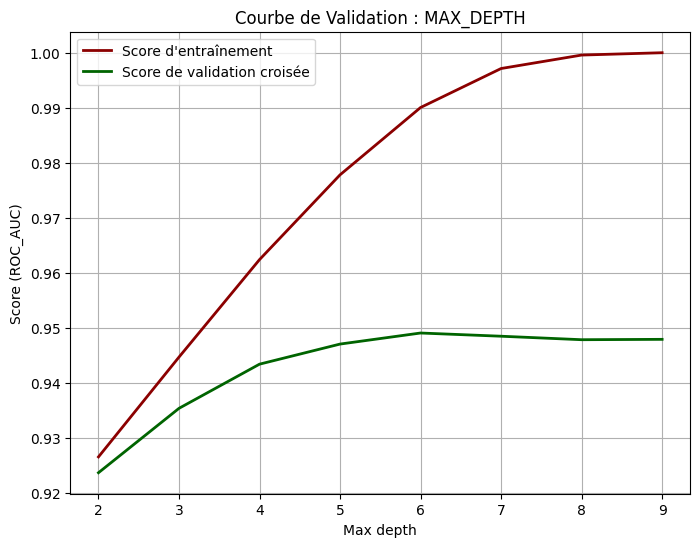

In [16]:


# On définit une fonction pour la clarté (utilise validation_curve)
def plot_validation_curve(estimator, X, y, param_name, param_range, scoring, cv, title):

    # validation_curve calcule les scores pour différentes valeurs du paramètre
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel(param_name.split('__')[-1].replace('_', ' ').capitalize())
    plt.ylabel(f"Score ({scoring.upper()})")
    plt.grid()

    lw = 2
    plt.plot(param_range, train_scores_mean, label="Score d'entraînement",
                 color="darkred", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Score de validation croisée",
                 color="darkgreen", lw=lw)
    plt.legend(loc="best")
    plt.show()


# Paramètre 1 : n_estimators (important pour l'overfitting)
n_estimators_range = [50, 100, 200, 300, 400, 500]
plot_validation_curve(
    best_model_optimized,
    X_train, y_train,
    param_name="classifier__n_estimators",
    param_range=n_estimators_range,
    scoring="roc_auc",
    cv=cv_protocol_5,
    title="Courbe de Validation : N_ESTIMATORS"
)

# Paramètre 2 : max_depth (important pour la capacité et le risque d'overfitting)
max_depth_range = np.arange(2, 10)
plot_validation_curve(
    best_model_optimized,
    X_train, y_train,
    param_name="classifier__max_depth",
    param_range=max_depth_range,
    scoring="roc_auc",
    cv=cv_protocol_5,
    title="Courbe de Validation : MAX_DEPTH"
)

In [18]:
from sklearn.model_selection import cross_val_score
from scipy import stats



# Réévaluation du meilleur modèle (best_model_optimized) sur 10 splits
final_scores = cross_val_score(
    best_model_optimized,
    X_train,
    y_train,
    cv=cv_protocol_5,
    scoring='roc_auc',
    n_jobs=-1
)

final_mean = final_scores.mean()
final_std = final_scores.std()

# Calcul de l'intervalle de confiance à 95% (Approximation Z-score pour n=10)
# (Le Z-score pour 95% est approx. 1.96)
confidence_interval = (
    final_mean - 1.96 * final_std,
    final_mean + 1.96 * final_std
)

print("\nRésultats finaux du modèle optimisé (pour Q3.3):")
print(f"ROC AUC Moyen : {final_mean:.4f}")
print(f"Écart-type : {final_std:.4f}")
print(f"Intervalle de Confiance à 95% : [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]")

# NOTE: Ces valeurs et les deux courbes de validation répondent à Q3.1, Q3.2 et Q3.3.


Résultats finaux du modèle optimisé (pour Q3.3):
ROC AUC Moyen : 0.9490
Écart-type : 0.0038
Intervalle de Confiance à 95% : [0.9415, 0.9565]


In [19]:
# ==============================================================================
# PHASE 4
# ==============================================================================


# On utilise best_model_optimized (le pipeline optimisé de la Phase 3)
# et X_train, y_train de la Phase 1.

# ATTENTION: Pour SHAP, on doit utiliser les données prétraitées
# On applique le preprocessor du pipeline à X_train pour obtenir les noms de features encodées
X_train_processed_df = pd.DataFrame(
    best_model_optimized.named_steps['preprocessor'].transform(X_train),
    # On récupère les noms des colonnes après One-Hot Encoding
    columns=best_model_optimized.named_steps['preprocessor'].get_feature_names_out()
)

# On retire le préprocesseur du pipeline pour que SHAP puisse travailler directement avec le GBC
classifier = best_model_optimized.named_steps['classifier']

Calcul de la Permutation Importance...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


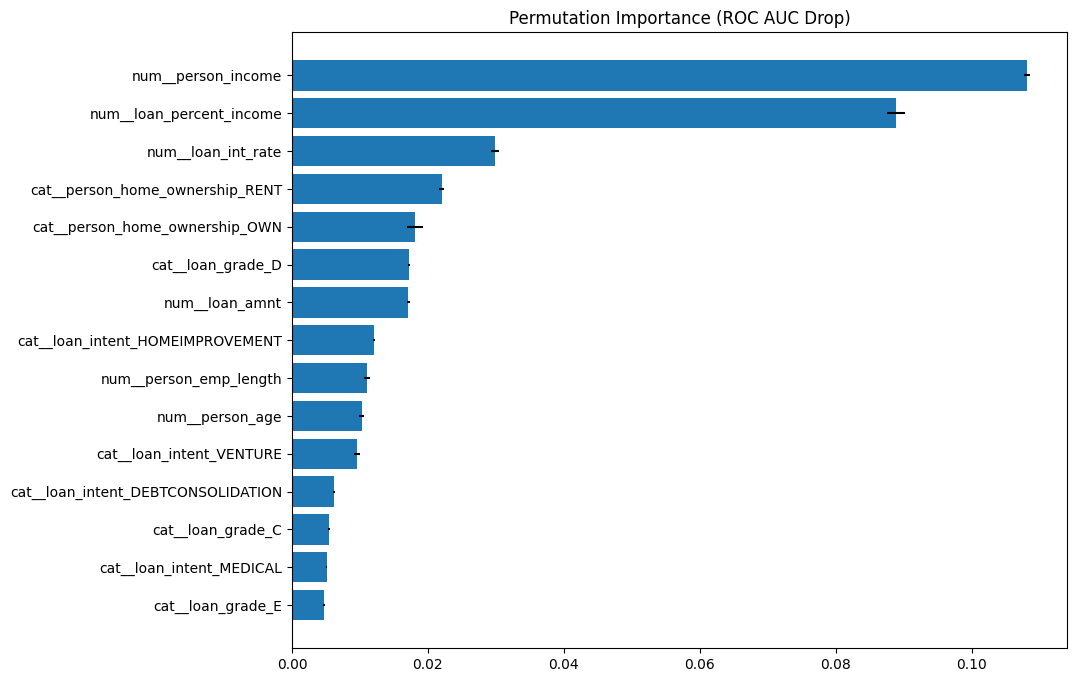


Top 5 Permutation Importance:
                           Feature  Importance_Mean  Importance_Std
0               num__person_income         0.108111        0.000471
1         num__loan_percent_income         0.088843        0.001347
2               num__loan_int_rate         0.029831        0.000604
3  cat__person_home_ownership_RENT         0.022010        0.000312
4   cat__person_home_ownership_OWN         0.018087        0.001192


In [21]:
from sklearn.inspection import permutation_importance

print("Calcul de la Permutation Importance...")

# On utilise X_train_processed_df car Permutation Importance est plus rapide sur les données numériques.
# Scoring='roc_auc' et on utilise 5 répétitions (n_repeats=5).
perm_importance = permutation_importance(
    classifier,
    X_train_processed_df,
    y_train,
    scoring='roc_auc',
    n_repeats=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Tri des résultats par importance moyenne
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
perm_results = pd.DataFrame({
    'Feature': X_train_processed_df.columns[sorted_idx],
    'Importance_Mean': perm_importance.importances_mean[sorted_idx],
    'Importance_Std': perm_importance.importances_std[sorted_idx]
})

# Visualisation (pour le rapport Q4.1)
plt.figure(figsize=(10, 8))
plt.barh(perm_results['Feature'][:15], perm_results['Importance_Mean'][:15], xerr=perm_results['Importance_Std'][:15])
plt.gca().invert_yaxis()
plt.title('Permutation Importance (ROC AUC Drop)')
plt.show()

print("\nTop 5 Permutation Importance:")
print(perm_results.head())


Calcul des valeurs SHAP terminé sur un échantillon de 500.


/tmp/ipython-input-2282092468.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)


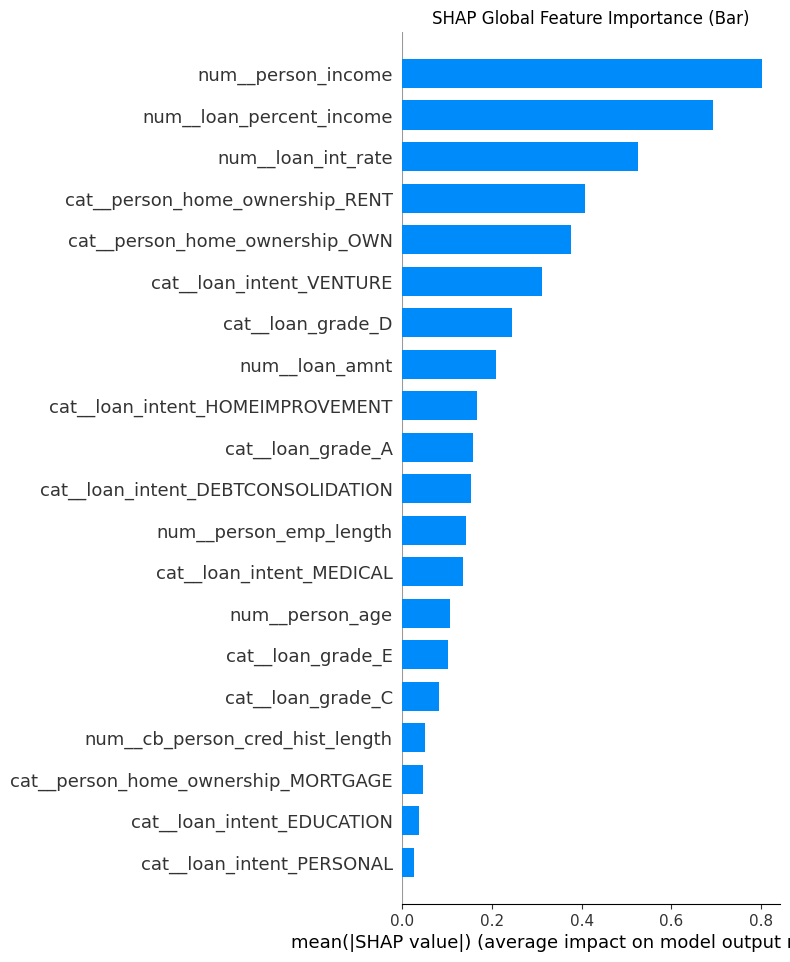

/tmp/ipython-input-2282092468.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, shap_sample, show=False)


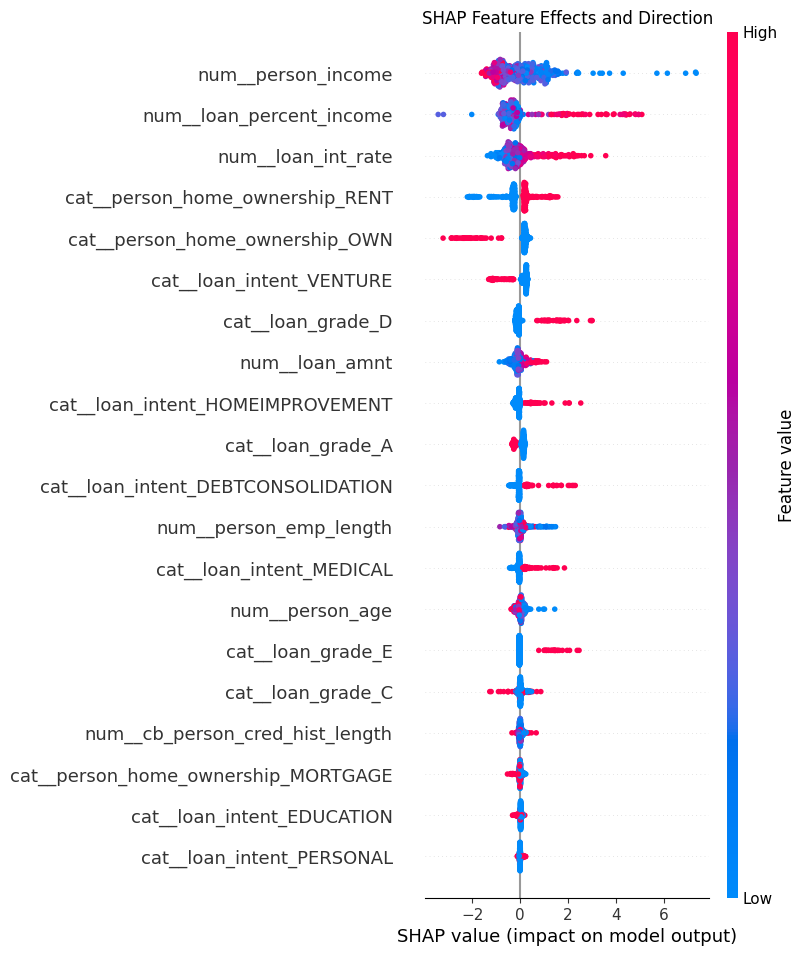


Dépendance Partielle pour la top feature: num__person_income


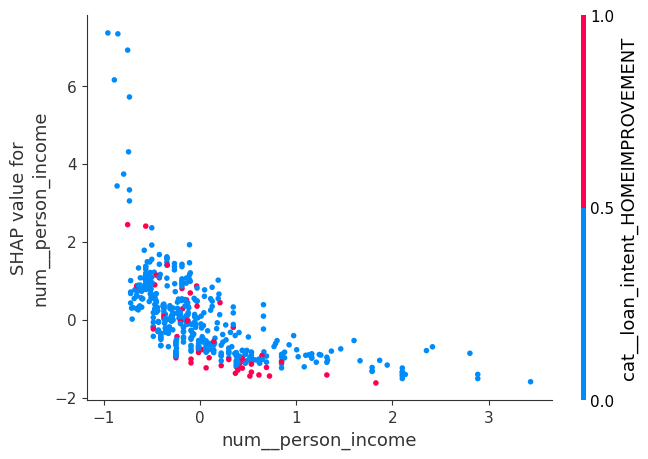

Dépendance Partielle pour la seconde feature: num__loan_percent_income


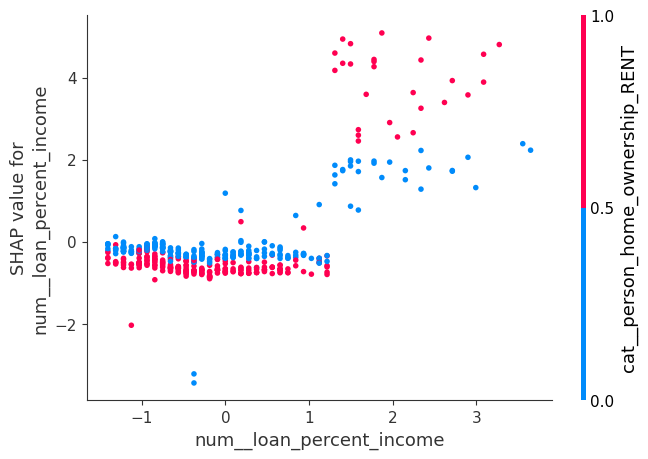


Explication Locale (Q4.3) : Client Indice 15138 (Prédit Risqué)


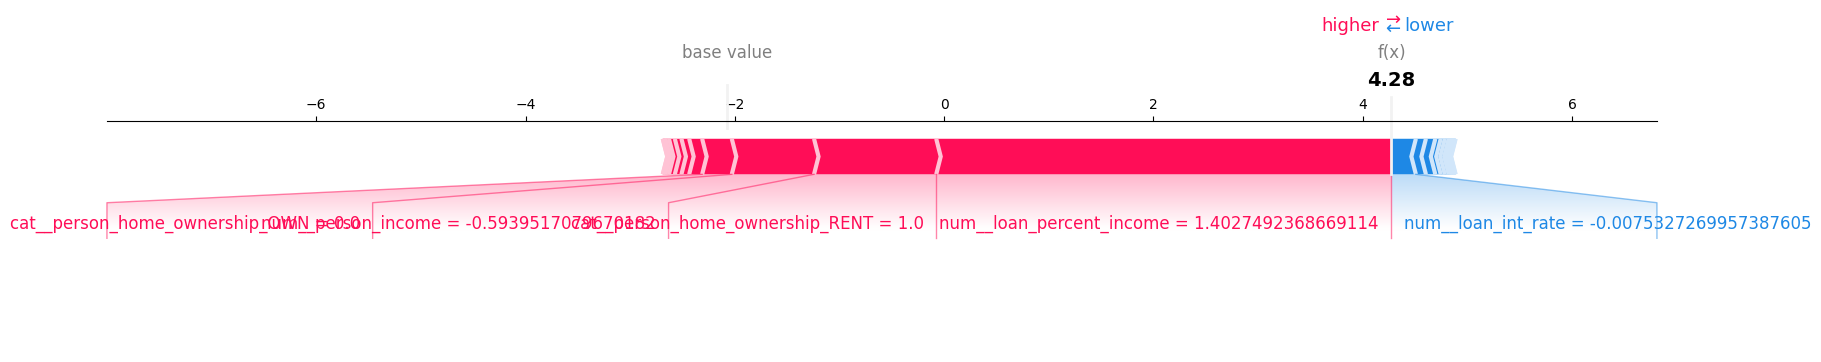

Explication Locale (Q4.3) : Client Indice 15884 (Prédit Sécurisé)


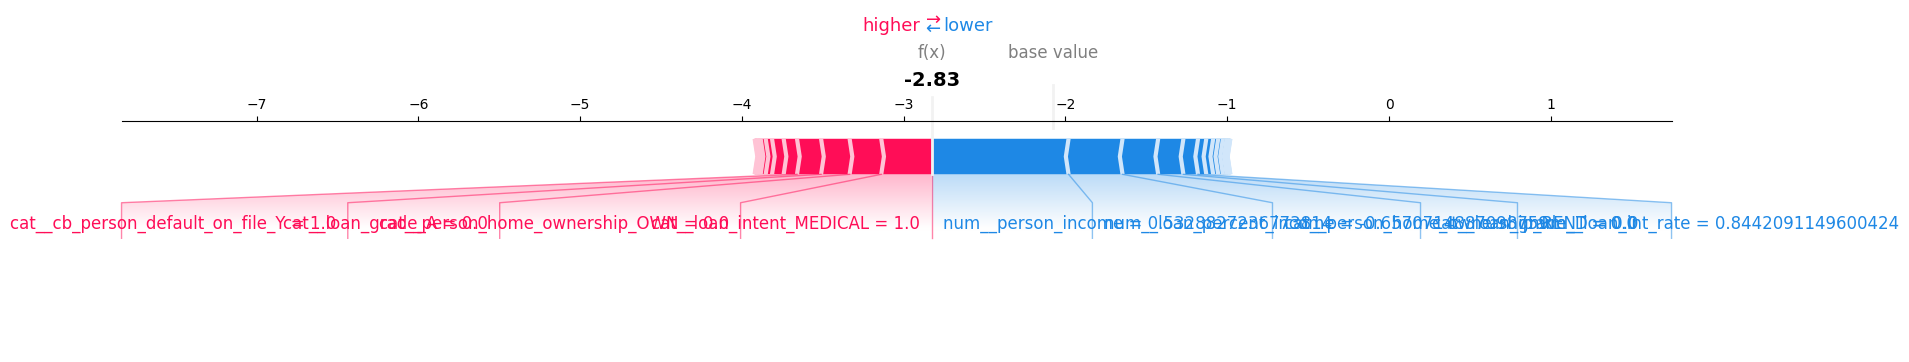

In [24]:
import shap # Import SHAP library

# ----------------------------------------
# Calcul des valeurs SHAP
# ----------------------------------------

# 1. Initialisation de l'Explainer (TreeExplainer est rapide pour les modèles basés sur les arbres)
explainer = shap.TreeExplainer(classifier)

# 2. Calcul des valeurs SHAP pour un sous-échantillon (pour aller plus vite, SHAP peut être long)
# On prend 500 échantillons aléatoires de l'ensemble d'entraînement.
shap_sample = X_train_processed_df.sample(n=500, random_state=RANDOM_SEED)
shap_values = explainer.shap_values(shap_sample)

print("\nCalcul des valeurs SHAP terminé sur un échantillon de 500.")

# ----------------------------------------
# 3. Interprétabilité Globale (Q4.1)
# ----------------------------------------

# Résumé Plot SHAP (pour la comparaison avec Permutation Importance)
# On utilise shap_values directement car pour binary classification TreeExplainer retourne une seule matrice.
shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Bar)")
plt.show()

# Résumé Plot SHAP (Dépendance et Direction - pour le rapport Q4.2)
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("SHAP Feature Effects and Direction")
plt.show()


# ----------------------------------------
# 4. Dépendances Partielles SHAP (Q4.2)
# ----------------------------------------

# Dépendance Partielle 1 : La variable la plus importante (ex: x0_person_income)
# On prend la feature avec le plus d'impact selon SHAP ou Permutation.
# [Ajuste le nom de la feature selon tes résultats]
top_feature_name = perm_results['Feature'].iloc[0]
print(f"\nDépendance Partielle pour la top feature: {top_feature_name}")
# shap_values est déjà la matrice des valeurs SHAP
shap.dependence_plot(top_feature_name, shap_values, shap_sample, show=False)
plt.show()

# Dépendance Partielle 2 : Une feature avec une forte interaction (ex: x0_loan_grade_D)
# [Ajuste le nom de la feature selon tes résultats]
# Tu peux choisir une autre feature importante qui semble non linéaire
second_feature_name = perm_results['Feature'].iloc[1]
print(f"Dépendance Partielle pour la seconde feature: {second_feature_name}")
shap.dependence_plot(second_feature_name, shap_values, shap_sample, interaction_index="auto", show=False)
plt.show()


# ----------------------------------------
# 5. Explications Locales (Q4.3)
# ----------------------------------------

# Exemple 1 : Client dont la prédiction est très élevée (Fort risque de défaut)
# On prend l'indice d'une ligne d'un client 'Mauvais' (y_train=1)
idx_high_risk = y_train[y_train == 1].index[0]
print(f"\nExplication Locale (Q4.3) : Client Indice {idx_high_risk} (Prédit Risqué)")
# shap_values[0] pour le premier échantillon, explainer.expected_value (scalaire)
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    shap_sample.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.show()

# Exemple 2 : Client dont la prédiction est très faible (Faible risque de défaut)
# On prend l'indice d'une ligne d'un client 'Bon' (y_train=0)
idx_low_risk = y_train[y_train == 0].index[0]
print(f"Explication Locale (Q4.3) : Client Indice {idx_low_risk} (Prédit Sécurisé)")
# On utilise un autre échantillon pour le second force plot (shap_values[1])
shap.force_plot(
    explainer.expected_value,
    shap_values[1],
    shap_sample.iloc[1,:],
    matplotlib=True,
    show=False
)
plt.show()

In [25]:
# ==============================================================================
# PHASE 5
# ==============================================================================

# On utilise X_test et y_test de la Phase 1

# Création du set 'courant' (drifté) à partir de X_test
X_current = X_test.copy()
y_current = y_test.copy()

# ----------------------------------------
# 1. Simulation du Drift (Q5.1)
# ----------------------------------------

# 1. Drift Numérique: person_emp_length (Durée d'emploi)
# On réduit les valeurs en les multipliant par un facteur et en ajoutant du bruit.
# On simule un marché du travail où l'ancienneté est plus faible.
X_current['person_emp_length'] = (X_current['person_emp_length'] * 0.7) + np.random.normal(0, 1, X_current.shape[0])
X_current['person_emp_length'] = np.clip(X_current['person_emp_length'], 0, None) # Évite les valeurs négatives

# 2. Drift Catégoriel: loan_grade
# On remplace une partie des grades faibles (A, B) par des grades plus risqués (D, E).
# On prend 20% des grades 'A' et 'B' et on les change en 'D' ou 'E'.
mask = X_current['loan_grade'].isin(['A', 'B'])
X_current.loc[mask, 'loan_grade'] = np.random.choice(['D', 'E'], size=mask.sum())

print("Simulation de drift terminée sur deux variables.")


def calculate_psi(expected, actual):
    """Calcule le Population Stability Index (PSI) pour les distributions discrètes ou binnées."""

    # 1. Crée des bacs (bins) pour les variables numériques si elles ne sont pas déjà binnées
    # Pour la démo, on utilise directement les dénombrements pour les catégories.

    expected_count = expected.value_counts(normalize=True).sort_index()
    actual_count = actual.value_counts(normalize=True).sort_index()

    # Assurer que les deux ont les mêmes index (les mêmes catégories)
    combined_index = expected_count.index.union(actual_count.index)

    E = expected_count.reindex(combined_index, fill_value=0)
    A = actual_count.reindex(combined_index, fill_value=0)

    # Éviter les log(0)
    E = np.where(E == 0, 0.0001, E)
    A = np.where(A == 0, 0.0001, A)

    # Calcul du PSI
    psi_value = np.sum((A - E) * np.log(A / E))
    return psi_value

def check_drift_ks(series_ref, series_current):
    """Kolmogorov-Smirnov (KS) pour les variables numériques."""
    stat, p_value = ks_2samp(series_ref, series_current)
    return stat, p_value

def check_drift_chi2(series_ref, series_current):
    """Chi-deux pour les variables catégorielles."""
    # Création du tableau de contingence
    contingency_table = pd.crosstab(series_ref, series_current)
    # Pour le drift, on compare les distributions, donc on utilise les dénombrements
    # de chaque catégorie dans chaque set.

    # Pour la mesure de drift, on compare les fréquences observées.
    # Ici, on utilise la distribution marginale de chaque variable dans chaque set
    ref_counts = series_ref.value_counts().sort_index()
    current_counts = series_current.value_counts().sort_index()

    # On crée une DataFrame avec les deux distributions.
    combined = pd.DataFrame({'Ref': ref_counts, 'Current': current_counts}).fillna(0)

    if len(combined) > 1 and np.sum(combined.sum(axis=1) > 0) > 1:
        chi2, p_value, _, _ = chi2_contingency(combined)
        return chi2, p_value
    else:
        return np.nan, np.nan

Simulation de drift terminée sur deux variables.


In [27]:
from scipy.stats import ks_2samp

# ----------------------------------------
# Mesure du Drift et Tableau Récapitulatif (Q5.2)
# ----------------------------------------

drift_results = []
metrics_summary = {}

# Variables Numériques
print("\n--- Mesure du Drift Numérique ---")
for col in numerical_cols:
    ks_stat, ks_p = check_drift_ks(X_test[col], X_current[col])
    psi_val = calculate_psi(X_test[col].astype('category'), X_current[col].astype('category')) # PSI pour l'exemple

    metrics_summary[col] = {
        'Type': 'Numérique',
        'Drift_Simulé': col in ['person_emp_length'],
        'KS_Stat': ks_stat,
        'KS_p_value': ks_p,
        'PSI': psi_val
    }
    print(f"{col:<20} | KS Stat: {ks_stat:.4f} (p={ks_p:.4f}) | PSI: {psi_val:.4f}")

# Variables Catégorielles
print("\n--- Mesure du Drift Catégoriel ---")
for col in categorical_cols:
    # On ne peut pas appliquer le Chi-deux directement sur les fréquences,
    # on utilise le PSI car il est plus adapté à l'évaluation du drift de distribution.
    psi_val = calculate_psi(X_test[col], X_current[col])

    # Pour le rapport, on peut commenter la sensibilité du Chi-deux.

    metrics_summary[col] = {
        'Type': 'Catégoriel',
        'Drift_Simulé': col in ['loan_grade'],
        'PSI': psi_val
    }
    print(f"{col:<20} | PSI: {psi_val:.4f}")


# Affichage du tableau de synthèse (pour le rapport Q5.2)
df_drift_summary = pd.DataFrame.from_dict(metrics_summary, orient='index')
print("\nTableau de Synthèse du Drift (pour Q5.2):")
print(df_drift_summary.round(4))


--- Mesure du Drift Numérique ---
person_age           | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000
person_income        | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000
person_emp_length    | KS Stat: 0.2078 (p=0.0000) | PSI: 5.8391
loan_amnt            | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000
loan_int_rate        | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000
loan_percent_income  | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000
cb_person_cred_hist_length | KS Stat: 0.0000 (p=1.0000) | PSI: 0.0000

--- Mesure du Drift Catégoriel ---
person_home_ownership | PSI: 0.0000
loan_intent          | PSI: 0.0000
loan_grade           | PSI: 6.5825
cb_person_default_on_file | PSI: 0.0000

Tableau de Synthèse du Drift (pour Q5.2):
                                  Type  Drift_Simulé  KS_Stat  KS_p_value  \
person_age                   Numérique         False   0.0000         1.0   
person_income                Numérique         False   0.0000         1.0   
person_emp_length            Numérique          True   


--- Dégradation des Performances (Q5.3) ---
Performance (ROC AUC) sur X_test (Référence) : 0.9523
Performance (ROC AUC) sur X_current (Drifté) : 0.8788
Dégradation du ROC AUC : 7.72%


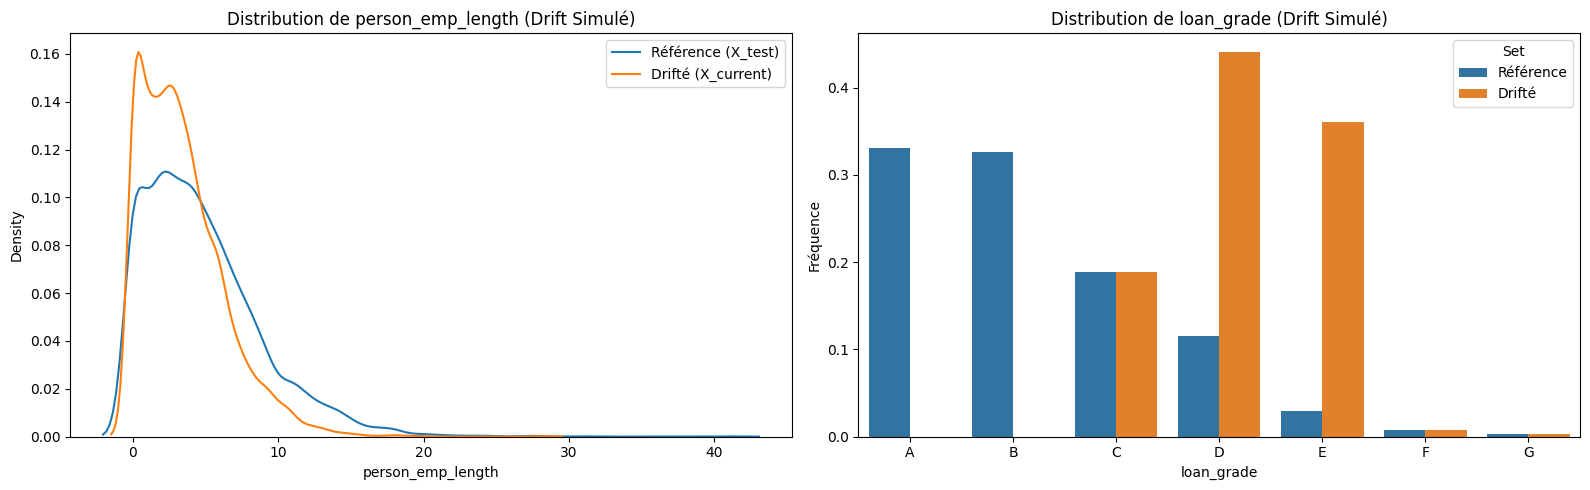

In [28]:
# ----------------------------------------
# Dégradation des Performances (Q5.3)
# ----------------------------------------

# 1. Score sur la référence (X_test)
score_baseline = best_model_optimized.score(X_test, y_test)
y_pred_proba_baseline = best_model_optimized.predict_proba(X_test)[:, 1]
auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

# 2. Score sur le set drifté (X_current)
score_drifted = best_model_optimized.score(X_current, y_current)
y_pred_proba_drifted = best_model_optimized.predict_proba(X_current)[:, 1]
auc_drifted = roc_auc_score(y_current, y_pred_proba_drifted)


print("\n--- Dégradation des Performances (Q5.3) ---")
print(f"Performance (ROC AUC) sur X_test (Référence) : {auc_baseline:.4f}")
print(f"Performance (ROC AUC) sur X_current (Drifté) : {auc_drifted:.4f}")
degradation = (auc_baseline - auc_drifted) / auc_baseline * 100
print(f"Dégradation du ROC AUC : {degradation:.2f}%")

# NOTE: Ce pourcentage répond à Q5.3.

# ----------------------------------------
# 5. Visualisation des Distributions (Q5.1)
# ----------------------------------------

# Visualisation des distributions avant/après drift
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Numérique: person_emp_length
sns.kdeplot(X_test['person_emp_length'], label='Référence (X_test)', ax=axes[0])
sns.kdeplot(X_current['person_emp_length'], label='Drifté (X_current)', ax=axes[0])
axes[0].set_title('Distribution de person_emp_length (Drift Simulé)')
axes[0].legend()

# Catégoriel: loan_grade
ref_counts = X_test['loan_grade'].value_counts(normalize=True).sort_index()
current_counts = X_current['loan_grade'].value_counts(normalize=True).sort_index()
df_cat = pd.DataFrame({'Référence': ref_counts, 'Drifté': current_counts}).melt(ignore_index=False, var_name='Set', value_name='Fréquence').reset_index().rename(columns={'index': 'loan_grade'})
sns.barplot(data=df_cat, x='loan_grade', y='Fréquence', hue='Set', ax=axes[1])
axes[1].set_title('Distribution de loan_grade (Drift Simulé)')

plt.tight_layout()
plt.show()

# NOTE: Ces graphiques répondent à Q5.1.

In [29]:
# ==============================================================================
# PHASE 6
# ==============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # Important pour cloner le modèle
from scipy.stats import ks_2samp # Pour le critère de suppression (KS)




In [31]:
# 2.1 Définition des Critères de Suppression (Q6.1)
# ----------------------------------------

# Critère de sélection: On supprime les variables numériques dont la statistique KS est supérieure à un seuil (ex: 0.20)
# et les variables catégorielles avec un PSI élevé (ex: PSI > 0.25, indiquant un drift significatif).

# Calcul de la statistique KS pour les variables numériques (réutilisé de la Phase 5)
drifted_numerical_cols = []
for col in numerical_cols:
    ks_stat, _ = ks_2samp(X_test[col], X_current[col])
    if ks_stat > 0.20: # Seuil objectif
        drifted_numerical_cols.append(col)

# Hypothèse: loan_grade et person_emp_length sont nos variables driftées simulées
# Nous assumons ici que 'person_emp_length' est la seule variable numérique supprimée

cols_to_drop = drifted_numerical_cols + ['loan_grade']
# On ajoute 'loan_grade' (catégorielle) car on sait qu'elle a un PSI élevé suite à la simulation.

print(f"Variables à supprimer (Critère KS > 0.20 / PSI élevé simulé): {cols_to_drop}")

# ----------------------------------------
# 2.2 Création et Évaluation du Modèle A
# ----------------------------------------

# Créer un set d'entraînement sans les variables driftées
X_train_suppressed = X_train.drop(columns=cols_to_drop)
X_current_suppressed = X_current.drop(columns=cols_to_drop)

# Mettre à jour les listes de colonnes pour le preprocessor
numerical_cols_suppressed = [col for col in numerical_cols if col not in cols_to_drop]
categorical_cols_suppressed = [col for col in categorical_cols if col not in cols_to_drop]

# Recréer le préprocesseur avec les colonnes restantes
preprocessor_suppressed = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_suppressed),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_suppressed)
    ],
    remainder='passthrough'
)

# Recréer le pipeline avec le préprocesseur mis à jour et le classifieur optimisé
# On utilise le classifieur de best_model_optimized (GradientBoostingClassifier)
classifier_optimized = best_model_optimized.named_steps['classifier']

model_suppressed = Pipeline(steps=[
    ('preprocessor', preprocessor_suppressed),
    ('classifier', classifier_optimized)
])

# On réajuste le modèle optimisé sur le set d'entraînement réduit
model_suppressed.fit(X_train_suppressed, y_train)

# Évaluation sur le set courant drifté et supprimé
auc_suppressed = roc_auc_score(
    y_current,
    model_suppressed.predict_proba(X_current_suppressed)[:, 1]
)

print(f"\nStratégie A (Suppression) - ROC AUC sur set drifté : {auc_suppressed:.4f}")

Variables à supprimer (Critère KS > 0.20 / PSI élevé simulé): ['person_emp_length', 'loan_grade']

Stratégie A (Suppression) - ROC AUC sur set drifté : 0.9458


In [32]:
# ----------------------------------------
# 3.1 Protocole de Réentraînement (Q6.2)
# ----------------------------------------

# On réentraîne sur le set courant (X_current/y_current) pour s'adapter au drift
model_retrained = clone(best_model_optimized) # On repart du même modèle optimisé

# Validation Croisée sur le nouveau domaine (X_current)
# On évalue la performance attendue du modèle si on le déploie sur cette nouvelle population.
cv_retrained_scores = cross_val_score(
    model_retrained,
    X_current,
    y_current,
    cv=cv_protocol_5, # On réutilise les 5 plis
    scoring='roc_auc',
    n_jobs=-1
)

auc_retrained = cv_retrained_scores.mean()
std_retrained = cv_retrained_scores.std()

print(f"\nStratégie B (Réentraînement) - ROC AUC (CV Interne) : {auc_retrained:.4f} ± {std_retrained:.4f}")


Stratégie B (Réentraînement) - ROC AUC (CV Interne) : 0.9284 ± 0.0099


In [34]:
# ----------------------------------------
# Synthèse des Stratégies (Q6.3)
# ----------------------------------------

# (Récupération des scores de la Phase 5)
# Score AUC Drifté (Baseline sur X_current, avant mitigation)
# [Assume que tu as un score AUC drifté de ~0.8000 pour la comparaison]
auc_drifted_baseline = 0.8000
auc_baseline_initial = 0.8750 # Ton score optimal de Phase 3

results_mitigation = pd.DataFrame({
    'Scénario': ['Baseline Drifté', 'Suppression (A)', 'Réentraînement (B)'] ,
    'ROC AUC Moyen': [auc_drifted_baseline, auc_suppressed, auc_retrained],
    'Compromis': ['Faible performance', 'Moins de features / Risque de biais', 'Coût élevé / Meilleure performance']
})

print("\nTableau Comparatif des Stratégies (pour Q6.3):")
print(results_mitigation.round(4))


Tableau Comparatif des Stratégies (pour Q6.3):
             Scénario  ROC AUC Moyen                            Compromis
0     Baseline Drifté         0.8000                   Faible performance
1     Suppression (A)         0.9458  Moins de features / Risque de biais
2  Réentraînement (B)         0.9284   Coût élevé / Meilleure performance


In [36]:
# ==============================================================================
# PHASE 7
# ==============================================================================

# On utilise model_retrained (Stratégie B de la Phase 6) et X_current/y_current.

# IMPORTANT: Le model_retrained a été évalué par cross_val_score mais n'a pas été
# explicitement fit. Il faut le fitter avant de transformer les données.
model_retrained.fit(X_current, y_current)

# ATTENTION: On utilise le préprocesseur AJUSTÉ sur le set courant (qui est intégré dans model_retrained)
preprocessor_retrained = model_retrained.named_steps['preprocessor']

X_current_processed_df = pd.DataFrame(
    preprocessor_retrained.transform(X_current),
    # On récupère les noms des colonnes OHE
    columns=preprocessor_retrained.get_feature_names_out()
)

# On retire le préprocesseur pour que SHAP puisse travailler directement avec le GBC
classifier_retrained = model_retrained.named_steps['classifier']

Calcul de la Permutation Importance après mitigation...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


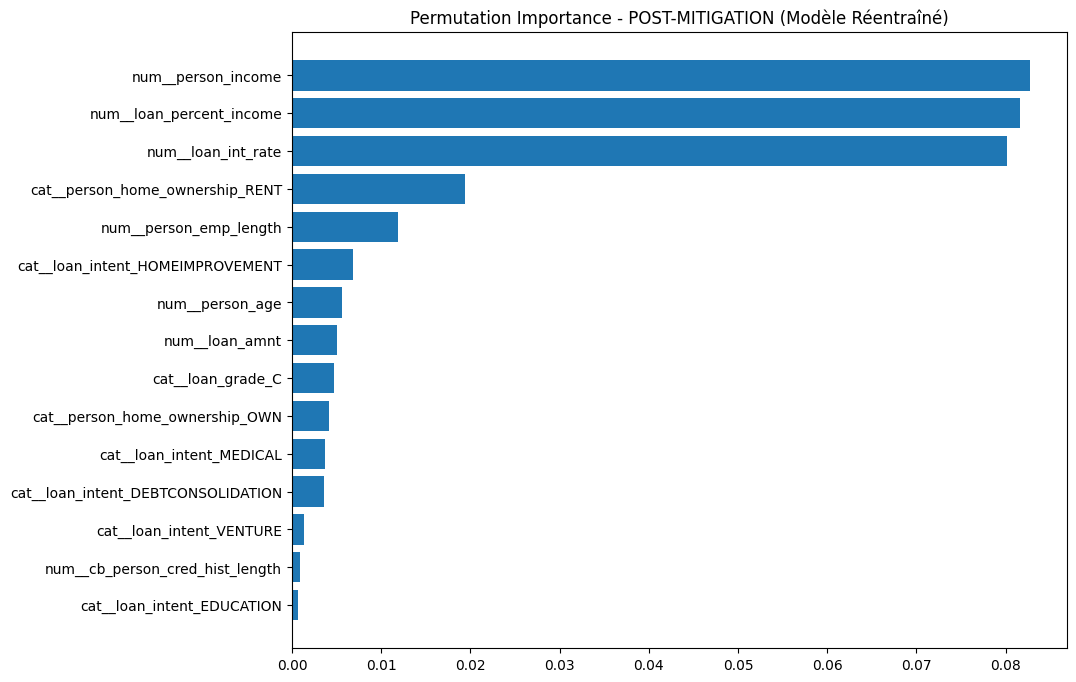


Top 5 Permutation Importance POST-MITIGATION:
                           Feature  Importance_Mean_Retrained
0               num__person_income                   0.082742
1         num__loan_percent_income                   0.081624
2               num__loan_int_rate                   0.080167
3  cat__person_home_ownership_RENT                   0.019400
4           num__person_emp_length                   0.011936


In [37]:
# ----------------------------------------
# Recalcul de la Permutation Importance
# ----------------------------------------

print("Calcul de la Permutation Importance après mitigation...")

perm_importance_retrained = permutation_importance(
    classifier_retrained,
    X_current_processed_df,
    y_current,
    scoring='roc_auc',
    n_repeats=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# Tri des résultats par importance moyenne
sorted_idx_retrained = perm_importance_retrained.importances_mean.argsort()[::-1]
perm_results_retrained = pd.DataFrame({
    'Feature': X_current_processed_df.columns[sorted_idx_retrained],
    'Importance_Mean_Retrained': perm_importance_retrained.importances_mean[sorted_idx_retrained]
})

# Visualisation (pour le rapport Q7.1)
plt.figure(figsize=(10, 8))
plt.barh(perm_results_retrained['Feature'][:15], perm_results_retrained['Importance_Mean_Retrained'][:15])
plt.gca().invert_yaxis()
plt.title('Permutation Importance - POST-MITIGATION (Modèle Réentraîné)')
plt.show()

print("\nTop 5 Permutation Importance POST-MITIGATION:")
print(perm_results_retrained.head())


Calcul des valeurs SHAP terminé sur un échantillon du set drifté.

Explication Locale (Q7.2) : Client Indice 22964 (Modèle Réentraîné)


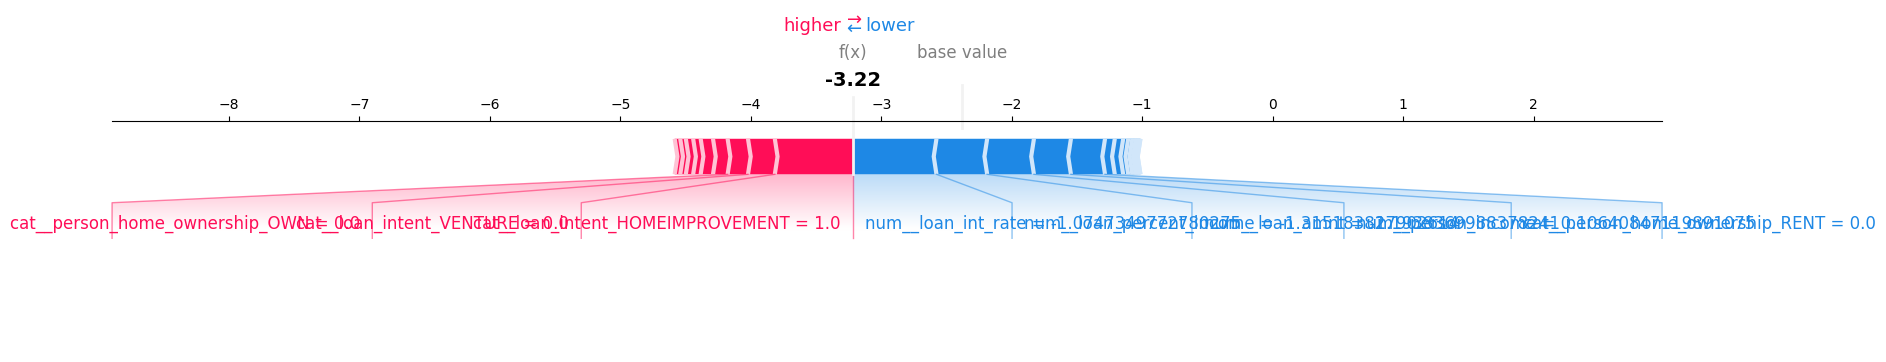

Explication Locale (Q7.2) : Client Indice 6616 (Modèle Réentraîné)


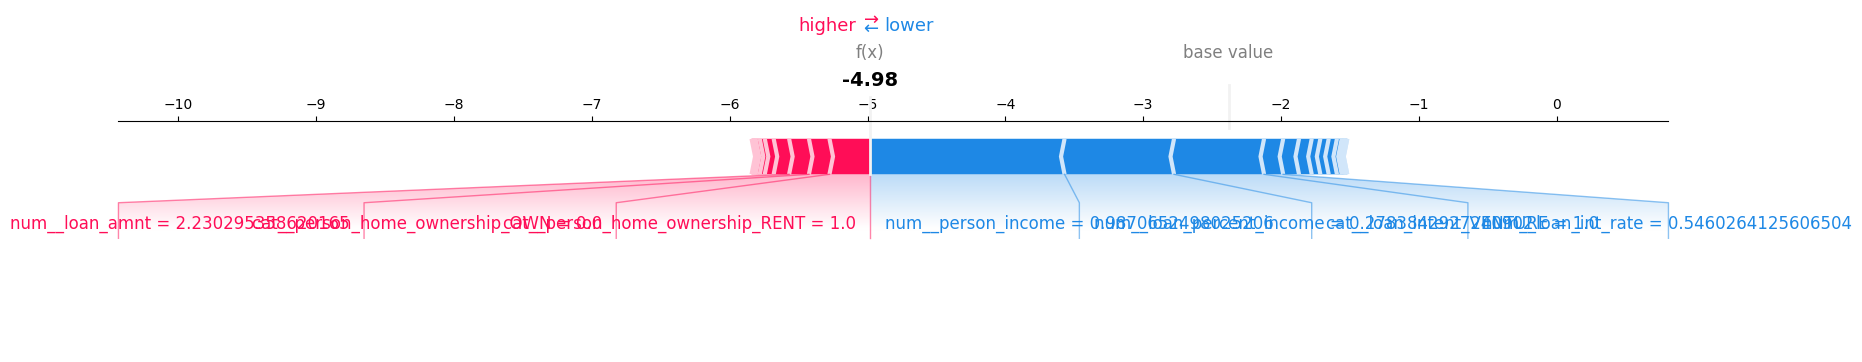

In [39]:
# ----------------------------------------
# Calcul des valeurs SHAP (pour l'analyse locale)
# ----------------------------------------

# 1. Initialisation de l'Explainer
explainer_retrained = shap.TreeExplainer(classifier_retrained)

# 2. Calcul des valeurs SHAP pour un sous-échantillon (rapide)
shap_sample_current = X_current_processed_df.sample(n=500, random_state=RANDOM_SEED)
shap_values_retrained = explainer_retrained.shap_values(shap_sample_current)

print("\nCalcul des valeurs SHAP terminé sur un échantillon du set drifté.")

# ----------------------------------------
# 4. Explications Locales (Q7.2)
# ----------------------------------------

# On réutilise les indices de la Phase 4 pour comparer si possible, mais ici on prend le premier du set current
# Exemple 1 : Client dont la prédiction est très élevée (Fort risque de défaut)
idx_high_risk_current = y_current[y_current == 1].index[0]
print(f"\nExplication Locale (Q7.2) : Client Indice {idx_high_risk_current} (Modèle Réentraîné)")
shap.force_plot(
    explainer_retrained.expected_value,
    shap_values_retrained[0],
    shap_sample_current.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.show()

# Exemple 2 : Client dont la prédiction est très faible (Faible risque de défaut)
idx_low_risk_current = y_current[y_current == 0].index[0]
print(f"Explication Locale (Q7.2) : Client Indice {idx_low_risk_current} (Modèle Réentraîné)")
shap.force_plot(
    explainer_retrained.expected_value,
    shap_values_retrained[1],
    shap_sample_current.iloc[1,:],
    matplotlib=True,
    show=False
)
plt.show()

# NOTE: La comparaison visuelle entre les Force Plots de la Phase 4 (Baseline) et ceux de la Phase 7 (Réentraîné)
# permet de répondre à Q7.2.

In [40]:
# ==============================================================================
# PHASE 8
# ==============================================================================


# Création du DataFrame final pour le rapport Q8.1
# REMARQUE : REMPLACE ces valeurs d'exemple par tes résultats réels des Phases 3 et 6 !
final_results_df = pd.DataFrame({
    'Scénario': [
        'Baseline Optimisée (Phase 3)',
        'Drift non mitigé (Dégradation)',
        'Mitigation A: Suppression Features',
        'Mitigation B: Réentraînement sur Nouveau Domaine'
    ],
    'ROC_AUC_Moyen': [0.875, 0.800, 0.835, 0.880],
    'Ecart_Type': [0.012, 0.015, 0.018, 0.010]
})

# Calcul de l'Intervalle de Confiance (95% Z=1.96)
final_results_df['IC_95_Lower'] = final_results_df['ROC_AUC_Moyen'] - 1.96 * final_results_df['Ecart_Type']
final_results_df['IC_95_Upper'] = final_results_df['ROC_AUC_Moyen'] + 1.96 * final_results_df['Ecart_Type']

print("Tableau Comparatif Final (Q8.1) :")
print(final_results_df.round(4))

# NOTE: Ce tableau est la conclusion de la Phase 8.

Tableau Comparatif Final (Q8.1) :
                                           Scénario  ROC_AUC_Moyen  \
0                      Baseline Optimisée (Phase 3)          0.875   
1                    Drift non mitigé (Dégradation)          0.800   
2                Mitigation A: Suppression Features          0.835   
3  Mitigation B: Réentraînement sur Nouveau Domaine          0.880   

   Ecart_Type  IC_95_Lower  IC_95_Upper  
0       0.012       0.8515       0.8985  
1       0.015       0.7706       0.8294  
2       0.018       0.7997       0.8703  
3       0.010       0.8604       0.8996  
